In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-21 14-36-02.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30 
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-21 14-36-02_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_02-test-01.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1753628593.122353 2486622 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1753628593.130446 2492041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753628593.134401 2492041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1753628593.857240 2492036 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 9860
Frames with at least 1 hand detected: 8299
Detection rate: 84.17%


In [1]:
df = pd.read_csv("hand_landmarks_02-test-02.csv")

print("Shape:", df.shape)
df

Shape: (292236, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.00,Left,0,NaN,NaN,NaN,0
1,0,0.00,Left,1,NaN,NaN,NaN,0
2,0,0.00,Left,2,NaN,NaN,NaN,0
3,0,0.00,Left,3,NaN,NaN,NaN,0
4,0,0.00,Left,4,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
292231,9859,164.35,Right,16,NaN,NaN,NaN,0
292232,9859,164.35,Right,17,NaN,NaN,NaN,0
292233,9859,164.35,Right,18,NaN,NaN,NaN,0
292234,9859,164.35,Right,19,NaN,NaN,NaN,0


In [2]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()
df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,298,4.966667,Right,1,0.577239,0.554877,0.535273,0.522460,0.512817,0.521160,...,-0.017418,-0.023391,-0.002469,-0.006621,-0.013614,-0.018408,-0.000389,-0.003218,-0.005332,-0.006684
1,317,5.283333,Left,1,0.600779,0.588325,0.559391,0.530103,0.504155,0.526894,...,-0.032166,-0.045086,0.010483,-0.007950,-0.028153,-0.038197,0.010172,-0.002913,-0.015406,-0.022792
2,318,5.300000,Left,1,0.589192,0.581398,0.557044,0.531901,0.508256,0.518697,...,-0.050922,-0.062453,-0.003070,-0.022181,-0.041296,-0.051193,0.000113,-0.012102,-0.024015,-0.031623
3,319,5.316667,Right,1,0.587533,0.571816,0.546861,0.526032,0.506063,0.517175,...,-0.050724,-0.060123,-0.015365,-0.034574,-0.049603,-0.056852,-0.018887,-0.032991,-0.042710,-0.048303
4,320,5.333333,Right,1,0.586884,0.568059,0.539717,0.517513,0.499955,0.518417,...,-0.040263,-0.046058,-0.010003,-0.027709,-0.039225,-0.043098,-0.012394,-0.025816,-0.034020,-0.037438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9839,9344,155.733333,Right,1,0.609859,0.628273,0.638872,0.643476,0.639209,0.601495,...,-0.053461,-0.058292,-0.023093,-0.035895,-0.040860,-0.043179,-0.015898,-0.025459,-0.028888,-0.030629
9840,9363,156.050000,Left,1,0.602536,0.589899,0.577123,0.566656,0.556542,0.580412,...,0.032414,0.031850,0.025728,0.035991,0.036300,0.034742,0.029306,0.037760,0.040049,0.040621
9841,9364,156.066667,Left,1,0.597199,0.586713,0.575515,0.565771,0.556603,0.576745,...,0.035648,0.036705,0.027454,0.038350,0.041242,0.041872,0.031525,0.041576,0.046160,0.048631
9842,9385,156.416667,Left,1,0.631980,0.606961,0.579943,0.557783,0.540972,0.619421,...,0.018003,0.016828,0.013896,0.019525,0.020413,0.020078,0.016429,0.021066,0.024460,0.026366


In [3]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,298,4.967,Right,1,0.577239,0.554877,0.535273,0.522460,0.512817,0.521160,...,-0.017418,-0.023391,-0.002469,-0.006621,-0.013614,-0.018408,-0.000389,-0.003218,-0.005332,-0.006684
1,317,5.283,Left,1,0.600779,0.588325,0.559391,0.530103,0.504155,0.526894,...,-0.032166,-0.045086,0.010483,-0.007950,-0.028153,-0.038197,0.010172,-0.002913,-0.015406,-0.022792
2,318,5.300,Left,1,0.589192,0.581398,0.557044,0.531901,0.508256,0.518697,...,-0.050922,-0.062453,-0.003070,-0.022181,-0.041296,-0.051193,0.000113,-0.012102,-0.024015,-0.031623
3,319,5.317,Right,1,0.587533,0.571816,0.546861,0.526032,0.506063,0.517175,...,-0.050724,-0.060123,-0.015365,-0.034574,-0.049603,-0.056852,-0.018887,-0.032991,-0.042710,-0.048303
4,320,5.333,Right,1,0.586884,0.568059,0.539717,0.517513,0.499955,0.518417,...,-0.040263,-0.046058,-0.010003,-0.027709,-0.039225,-0.043098,-0.012394,-0.025816,-0.034020,-0.037438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9839,9344,155.733,Right,1,0.609859,0.628273,0.638872,0.643476,0.639209,0.601495,...,-0.053461,-0.058292,-0.023093,-0.035895,-0.040860,-0.043179,-0.015898,-0.025459,-0.028888,-0.030629
9840,9363,156.050,Left,1,0.602536,0.589899,0.577123,0.566656,0.556542,0.580412,...,0.032414,0.031850,0.025728,0.035991,0.036300,0.034742,0.029306,0.037760,0.040049,0.040621
9841,9364,156.067,Left,1,0.597199,0.586713,0.575515,0.565771,0.556603,0.576745,...,0.035648,0.036705,0.027454,0.038350,0.041242,0.041872,0.031525,0.041576,0.046160,0.048631
9842,9385,156.417,Left,1,0.631980,0.606961,0.579943,0.557783,0.540972,0.619421,...,0.018003,0.016828,0.013896,0.019525,0.020413,0.020078,0.016429,0.021066,0.024460,0.026366


In [6]:
df2 = pd.read_csv("hand_lable_02-test-02.csv")

print("Shape:", df.shape)
df2

Shape: (292236, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,02-test-02,2025-07-27 20:06:55.052,NaN,141.384,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,164.333,60.0,NaN,hold,NaN,START,16.283,D:/Data Science/UOB/DS_project/Prototype/02-te...,977,NaN,NaN
1,02-test-02,2025-07-27 20:06:55.052,NaN,141.384,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,164.333,60.0,NaN,hold,NaN,STOP,21.483,D:/Data Science/UOB/DS_project/Prototype/02-te...,1289,NaN,NaN
2,02-test-02,2025-07-27 20:06:55.052,NaN,141.384,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,164.333,60.0,NaN,press,NaN,START,21.500,D:/Data Science/UOB/DS_project/Prototype/02-te...,1290,NaN,NaN
3,02-test-02,2025-07-27 20:06:55.052,NaN,141.384,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,164.333,60.0,NaN,press,NaN,STOP,22.367,D:/Data Science/UOB/DS_project/Prototype/02-te...,1342,NaN,NaN
4,02-test-02,2025-07-27 20:06:55.052,NaN,141.384,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,164.333,60.0,NaN,hold,NaN,START,22.383,D:/Data Science/UOB/DS_project/Prototype/02-te...,1343,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,02-test-02,2025-07-27 20:06:55.052,NaN,141.384,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,164.333,60.0,NaN,hold,NaN,STOP,154.867,D:/Data Science/UOB/DS_project/Prototype/02-te...,9292,NaN,NaN
172,02-test-02,2025-07-27 20:06:55.052,NaN,141.384,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,164.333,60.0,NaN,place,NaN,START,154.883,D:/Data Science/UOB/DS_project/Prototype/02-te...,9293,NaN,NaN
173,02-test-02,2025-07-27 20:06:55.052,NaN,141.384,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,164.333,60.0,NaN,place,NaN,STOP,156.133,D:/Data Science/UOB/DS_project/Prototype/02-te...,9368,NaN,NaN
174,02-test-02,2025-07-27 20:06:55.052,NaN,141.384,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,164.333,60.0,NaN,other,NaN,START,156.150,D:/Data Science/UOB/DS_project/Prototype/02-te...,9369,NaN,NaN


In [7]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,hold,16.283,21.483,977,1289
1,press,21.500,22.367,1290,1342
2,hold,22.383,23.000,1343,1380
3,press,23.017,24.233,1381,1454
4,hold,24.250,25.217,1455,1513
...,...,...,...,...,...
83,hold,141.750,142.050,8505,8523
84,rotate,142.067,152.067,8524,9124
85,hold,152.083,154.867,9125,9292
86,place,154.883,156.133,9293,9368


In [8]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_25819/222154802.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'hold' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,298,4.967,Right,1,0.577239,0.554877,0.535273,0.522460,0.512817,0.521160,...,-0.023391,-0.002469,-0.006621,-0.013614,-0.018408,-0.000389,-0.003218,-0.005332,-0.006684,NaN
1,317,5.283,Left,1,0.600779,0.588325,0.559391,0.530103,0.504155,0.526894,...,-0.045086,0.010483,-0.007950,-0.028153,-0.038197,0.010172,-0.002913,-0.015406,-0.022792,NaN
2,318,5.300,Left,1,0.589192,0.581398,0.557044,0.531901,0.508256,0.518697,...,-0.062453,-0.003070,-0.022181,-0.041296,-0.051193,0.000113,-0.012102,-0.024015,-0.031623,NaN
3,319,5.317,Right,1,0.587533,0.571816,0.546861,0.526032,0.506063,0.517175,...,-0.060123,-0.015365,-0.034574,-0.049603,-0.056852,-0.018887,-0.032991,-0.042710,-0.048303,NaN
4,320,5.333,Right,1,0.586884,0.568059,0.539717,0.517513,0.499955,0.518417,...,-0.046058,-0.010003,-0.027709,-0.039225,-0.043098,-0.012394,-0.025816,-0.034020,-0.037438,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9839,9344,155.733,Right,1,0.609859,0.628273,0.638872,0.643476,0.639209,0.601495,...,-0.058292,-0.023093,-0.035895,-0.040860,-0.043179,-0.015898,-0.025459,-0.028888,-0.030629,place
9840,9363,156.050,Left,1,0.602536,0.589899,0.577123,0.566656,0.556542,0.580412,...,0.031850,0.025728,0.035991,0.036300,0.034742,0.029306,0.037760,0.040049,0.040621,place
9841,9364,156.067,Left,1,0.597199,0.586713,0.575515,0.565771,0.556603,0.576745,...,0.036705,0.027454,0.038350,0.041242,0.041872,0.031525,0.041576,0.046160,0.048631,place
9842,9385,156.417,Left,1,0.631980,0.606961,0.579943,0.557783,0.540972,0.619421,...,0.016828,0.013896,0.019525,0.020413,0.020078,0.016429,0.021066,0.024460,0.026366,other


In [9]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
rotate    3507
hold      1955
adjust    1841
press     1825
NaN        704
place       10
other        2
Name: count, dtype: int64


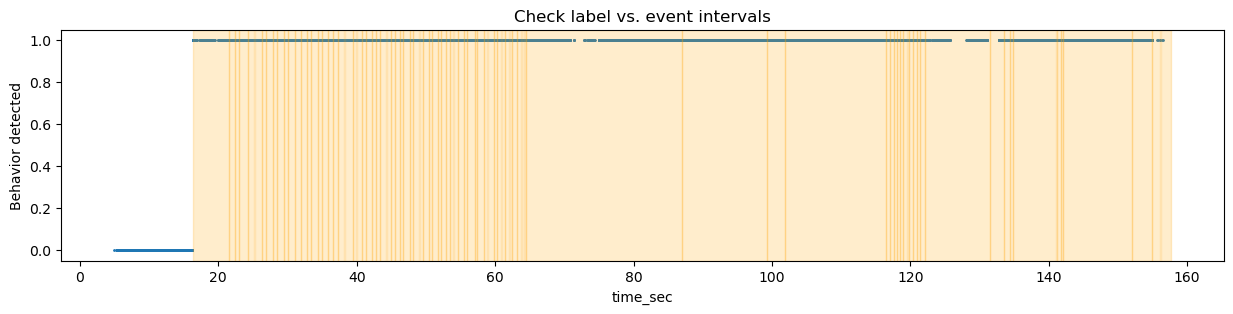

In [10]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [11]:
nan_counts = df_wide.isna().sum()

total_rows = len(df_wide)

nan_report = pd.DataFrame({
    'num_nan': nan_counts,
    'percent_nan': (nan_counts / total_rows) * 100
})

nan_report

,num_nan,percent_nan
frame,0,0.000000
time_sec,0,0.000000
hand,0,0.000000
hand_detected,0,0.000000
x_0,0,0.000000
...,...,...
z_17,0,0.000000
z_18,0,0.000000
z_19,0,0.000000
z_20,0,0.000000


In [12]:
df_wide_clean = df_wide.dropna()

df_wide_clean

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
704,977,16.283,Right,1,0.755971,0.791819,0.798522,0.789442,0.771729,0.813698,...,0.040584,-0.000957,0.006013,0.016585,0.022811,-0.014279,-0.011625,-0.004208,0.001786,hold
705,978,16.300,Right,1,0.748458,0.778745,0.785746,0.774262,0.754876,0.801995,...,0.042712,-0.003698,0.002007,0.013416,0.020675,-0.016076,-0.016093,-0.009366,-0.003237,hold
706,979,16.317,Right,1,0.747995,0.764469,0.772731,0.765016,0.748108,0.785728,...,0.027606,-0.001934,0.003363,0.014528,0.021810,-0.006231,-0.001865,0.007794,0.015834,hold
707,980,16.333,Right,1,0.748642,0.764492,0.772231,0.765496,0.750889,0.785193,...,0.032882,0.001206,0.007396,0.018536,0.025937,-0.004077,0.000787,0.010684,0.018998,hold
708,981,16.350,Left,1,0.744916,0.706632,0.701064,0.709392,0.717612,0.734768,...,0.003827,-0.007533,-0.004524,0.001894,0.005904,-0.004807,-0.000642,0.006346,0.011930,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9839,9344,155.733,Right,1,0.609859,0.628273,0.638872,0.643476,0.639209,0.601495,...,-0.058292,-0.023093,-0.035895,-0.040860,-0.043179,-0.015898,-0.025459,-0.028888,-0.030629,place
9840,9363,156.050,Left,1,0.602536,0.589899,0.577123,0.566656,0.556542,0.580412,...,0.031850,0.025728,0.035991,0.036300,0.034742,0.029306,0.037760,0.040049,0.040621,place
9841,9364,156.067,Left,1,0.597199,0.586713,0.575515,0.565771,0.556603,0.576745,...,0.036705,0.027454,0.038350,0.041242,0.041872,0.031525,0.041576,0.046160,0.048631,place
9842,9385,156.417,Left,1,0.631980,0.606961,0.579943,0.557783,0.540972,0.619421,...,0.016828,0.013896,0.019525,0.020413,0.020078,0.016429,0.021066,0.024460,0.026366,other


In [13]:
behavior_counts = df_wide_clean['behavior'].value_counts()

print(behavior_counts)

behavior
rotate    3507
hold      1955
adjust    1841
press     1825
place       10
other        2
Name: count, dtype: int64


In [14]:
df_wide_clean['dataset_id'] = '02-test-02'

cols = df_wide_clean.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide_clean = df_wide_clean[cols]

df_wide_clean

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_25819/1858969395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wide_clean['dataset_id'] = '02-test-02'


,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
704,02-test-02,977,16.283,Right,1,0.755971,0.791819,0.798522,0.789442,0.771729,...,0.040584,-0.000957,0.006013,0.016585,0.022811,-0.014279,-0.011625,-0.004208,0.001786,hold
705,02-test-02,978,16.300,Right,1,0.748458,0.778745,0.785746,0.774262,0.754876,...,0.042712,-0.003698,0.002007,0.013416,0.020675,-0.016076,-0.016093,-0.009366,-0.003237,hold
706,02-test-02,979,16.317,Right,1,0.747995,0.764469,0.772731,0.765016,0.748108,...,0.027606,-0.001934,0.003363,0.014528,0.021810,-0.006231,-0.001865,0.007794,0.015834,hold
707,02-test-02,980,16.333,Right,1,0.748642,0.764492,0.772231,0.765496,0.750889,...,0.032882,0.001206,0.007396,0.018536,0.025937,-0.004077,0.000787,0.010684,0.018998,hold
708,02-test-02,981,16.350,Left,1,0.744916,0.706632,0.701064,0.709392,0.717612,...,0.003827,-0.007533,-0.004524,0.001894,0.005904,-0.004807,-0.000642,0.006346,0.011930,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9839,02-test-02,9344,155.733,Right,1,0.609859,0.628273,0.638872,0.643476,0.639209,...,-0.058292,-0.023093,-0.035895,-0.040860,-0.043179,-0.015898,-0.025459,-0.028888,-0.030629,place
9840,02-test-02,9363,156.050,Left,1,0.602536,0.589899,0.577123,0.566656,0.556542,...,0.031850,0.025728,0.035991,0.036300,0.034742,0.029306,0.037760,0.040049,0.040621,place
9841,02-test-02,9364,156.067,Left,1,0.597199,0.586713,0.575515,0.565771,0.556603,...,0.036705,0.027454,0.038350,0.041242,0.041872,0.031525,0.041576,0.046160,0.048631,place
9842,02-test-02,9385,156.417,Left,1,0.631980,0.606961,0.579943,0.557783,0.540972,...,0.016828,0.013896,0.019525,0.020413,0.020078,0.016429,0.021066,0.024460,0.026366,other


In [15]:
df_wide_clean.to_csv("handlandmark_wide_02-test-02.csv", index=False)